In [ ]:
""" import """

import torch
import numpy as np
import pandas as pd
import scipy.io
import scipy.stats

import os
import tqdm
import warnings
import dataclasses
import matplotlib.pyplot as plt

import src

if torch.cuda.is_available(): device = "cuda"
elif torch.backends.mps.is_available(): device = "mps"
else: device = "cpu"

# disable MPS UserWarning: The operator 'aten::col2im' is not currently 
# supported on the MPS backend
warnings.filterwarnings("ignore", message=".*MPS.*fallback.*")

def ckptFinder(config: src.config.Config, epoch: int | None = None) -> str:
    root = config.trainer.ckpt_save_fold
    name = config.__class__.__name__
    target = "last" if epoch is None else f"epoch={epoch}"
    for f in os.listdir(os.path.join(root, name)):
        if target in f and f.endswith(".ckpt"):
            return os.path.join(root, name, f)
    raise FileNotFoundError

In [ ]:
""" config """

config = src.config.ConfigD03()
config.data.data_load_fold
config.data.channel_perm = False
config.data.channel_drop = 0
config.data.channel_shift = 0
config.trainer.ckpt_load_path = ckptFinder(config, epoch=None)
print(f"load ckpt from {config.trainer.ckpt_load_path}")
L = (1000 - config.model.S) // config.model.stride + 1
SCALE = 29.7240     # for bp's z-score normalization
BIAS  = 116.7494    # for bp's z-score normalization

load ckpt from ckpt/ConfigD03/last.ckpt


In [ ]:
""" initialize data and model """

# data
data = src.data.RawDataModule(**dataclasses.asdict(config.data))
data.setup()
# model
model = src.model.SCOST(**dataclasses.asdict(config.model))
ckpt = torch.load(
    config.trainer.ckpt_load_path, weights_only=True, 
        map_location=torch.device(device)
)
state_dict = {
    k.replace("model.", ""): v for k, v in ckpt["state_dict"].items()
    if k.startswith("model.")
}
state_dict = {
    (k.replace("head_reconstruction", "head_recon_raw")
     if k.startswith("head_reconstruction") else k): v
    for k, v in state_dict.items()
}
print(
    "warning: replace head_reconstruction with",
    "head_recon_raw in ckpt state_dict!"
)
model.load_state_dict(state_dict, strict=False)
model = model.eval().to(device)

In [ ]:
""" profile group by set """

# get valid samples
x = torch.load(
    os.path.join(config.data.data_load_fold, "x.pt"), weights_only=True
)
valid = torch.where(~torch.isnan(x).any(dim=(1, 2)))[0]
# load profile and filter invalid samples
profile = pd.read_csv(os.path.join(config.data.data_load_fold, "sample.csv"))
profile = profile.iloc[valid.numpy()].reset_index(drop=True)
# split
s = torch.as_tensor(profile[config.data.split].to_numpy(), dtype=torch.long)
tr = torch.as_tensor(s == 0, dtype=torch.bool)
va = torch.as_tensor(s == 1, dtype=torch.bool)
te = torch.as_tensor(s == 2, dtype=torch.bool)
profile_tr = profile[tr.numpy()].reset_index(drop=True)
profile_va = profile[va.numpy()].reset_index(drop=True)
profile_te = profile[te.numpy()].reset_index(drop=True)
# combine valid and test as one test
profile_te = pd.concat([profile_va, profile_te], ignore_index=True)
profile_set = {"tr": profile_tr.iloc[:, :5], "te": profile_te.iloc[:, :5]}
# print shape
print(profile_set["tr"].keys().to_list())
print("profile_set['tr']: pd.DataFrame\t", profile_set["tr"].shape)
print("profile_set['te']: pd.DataFrame\t", profile_set["te"].shape)

['subject', 'health', 'system', 'repeat', 'condition']
profile_set['tr']: pd.DataFrame	 (10689, 5)
profile_set['te']: pd.DataFrame	 (10903, 5)


In [ ]:
""" result group by set """

result_set = {}
for set, dataloader in zip(
    ["tr", "va", "te"], 
    [data.train_dataloader(), data.val_dataloader(), data.test_dataloader()]
):
    result_b = []
    for batch in tqdm.tqdm(dataloader):
        x, channel_idx = batch
        x, channel_idx = x.to(device), channel_idx.to(device)
        # remove sample in batch that contains -1 in channel_idx
        valid = (channel_idx != -1).all(dim=1)
        if valid.sum() == 0: continue
        x, channel_idx = x[valid], channel_idx[valid]
        # forward
        with torch.no_grad(): x_pred, _ = model.forwardReconstructionRaw(
            x, channel_idx, user_mask=3
        )
        # store result
        result_b.append(torch.cat([
            x.detach().cpu(),                               # (B, 3, T)
            x_pred[:, 3, :].detach().cpu().unsqueeze(1)     # (B, 1, T)
        ], dim=1))
    result_set[set] = torch.cat(result_b, dim=0)            # (N, 4, T)
    # map bp in 3nd and 4th channel to waveform before normalization
    # and store new waveform in 5th and 6th channel
    result_set[set] = torch.cat([
        result_set[set], 
        (result_set[set][:, 3, :] * SCALE + BIAS).unsqueeze(1),
        (result_set[set][:, 4, :] * SCALE + BIAS).unsqueeze(1),
    ], dim=1).detach().cpu()
# combine valid and test result into one test result
result_set["te"] = torch.cat([result_set["va"], result_set["te"]], dim=0)
# remove validation from dictionary
del result_set["va"]
# print number of sample in each set
for set in result_set: 
    print(f"result_s['{set}']: torch.Tensor\t", result_set[set].shape)

100%|██████████| 38/38 [00:11<00:00,  3.34it/s]

result_s['tr']: torch.Tensor	 torch.Size([10689, 7, 1000])
result_s['te']: torch.Tensor	 torch.Size([10903, 7, 1000])


In [ ]:
""" result and profile group by subject """

result_sub = {}
for set in result_set:
    for subject in profile_set[set]["subject"].unique():
        idx = profile_set[set].index[
            profile_set[set]["subject"] == subject
        ].tolist()
        result_sub[subject] = result_set[set][idx]
profile_sub = {}
for set in profile_set:
    for subject in profile_set[set]["subject"].unique():
        idx = profile_set[set]["subject"] == subject
        profile_sub[subject] = profile_set[set][idx]

tr
MAE (all): 6.30 mmHg
MAE (min): 5.38 mmHg
MAE (max): 6.69 mmHg
te
MAE (all): 18.55 mmHg
MAE (min): 15.68 mmHg
MAE (max): 21.63 mmHg


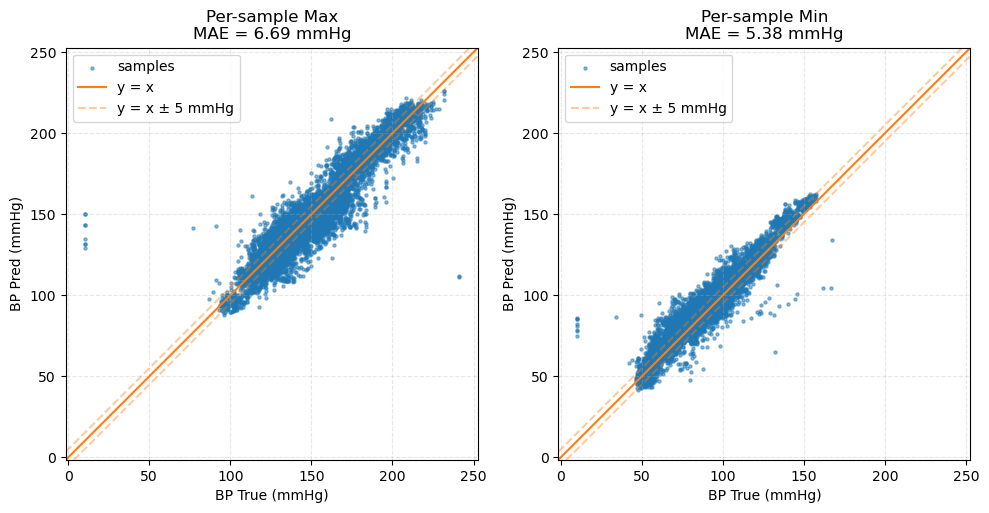

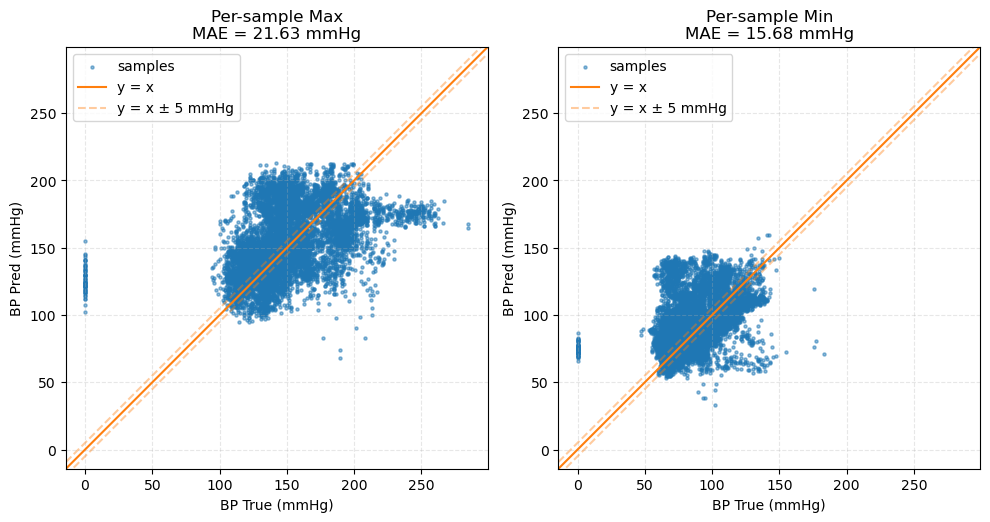

In [ ]:
""" loss and visualization """

for set in result_set:
    true_min = result_set[set][:, 5].min(dim=1).values    # (N,)
    true_max = result_set[set][:, 5].max(dim=1).values    # (N,)
    pred_min = result_set[set][:, 6].min(dim=1).values    # (N,)
    pred_max = result_set[set][:, 6].max(dim=1).values    # (N,)
    # loss
    mae_all = torch.nn.functional.l1_loss(
        result_set[set][:, 5], result_set[set][:, 6]
    ).item()
    mae_min = torch.nn.functional.l1_loss(pred_min, true_min).item()
    mae_max = torch.nn.functional.l1_loss(pred_max, true_max).item()
    # print
    print(set)
    print(f"MAE (all): {mae_all:.2f} mmHg")
    print(f"MAE (min): {mae_min:.2f} mmHg")
    print(f"MAE (max): {mae_max:.2f} mmHg")
    # plot
    all_vals = np.concatenate([true_max, pred_max, true_min, pred_min])
    pad = max(2.0, 0.05 * (all_vals.max() - all_vals.min()))
    lo, hi = all_vals.min() - pad, all_vals.max() + pad
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # --- Max ---
    ax = axes[0]
    ax.scatter(true_max, pred_max, s=5, alpha=0.5, label="samples")
    # y=x (ideal)
    ax.plot([lo, hi], [lo, hi], color="C1", lw=1.5, label="y = x")
    # y=x±5 (reference)
    ax.plot(
        [lo, hi], [lo+5, hi+5], color="C1", lw=1.5, ls="--", alpha=0.4, 
        label="y = x ± 5 mmHg"
    )
    ax.plot(
        [lo, hi], [lo-5, hi-5], color="C1", lw=1.5, ls="--", alpha=0.4
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_xlabel("BP True (mmHg)")
    ax.set_ylabel("BP Pred (mmHg)")
    ax.set_title(f"Per-sample Max\nMAE = {mae_max:.2f} mmHg")
    ax.grid(True, ls="--", alpha=0.3)
    ax.legend()
    # --- Min ---
    ax = axes[1]
    ax.scatter(true_min, pred_min, s=5, alpha=0.5, label="samples")
    # y=x (ideal)
    ax.plot([lo, hi], [lo, hi], color="C1", lw=1.5, label="y = x")
    # y=x±5 (reference)
    ax.plot(
        [lo, hi], [lo+5, hi+5], color="C1", lw=1.5, ls="--", alpha=0.4, 
        label="y = x ± 5 mmHg"
    )
    ax.plot(
        [lo, hi], [lo-5, hi-5], color="C1", lw=1.5, ls="--", alpha=0.4
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_xlabel("BP True (mmHg)")
    ax.set_ylabel("BP Pred (mmHg)")
    ax.set_title(f"Per-sample Min\nMAE = {mae_min:.2f} mmHg")
    ax.grid(True, ls="--", alpha=0.3)
    ax.legend()
    # --- Show ---
    plt.tight_layout()
plt.show()

In [ ]:
""" config """

s = 0
sub = 'S002'

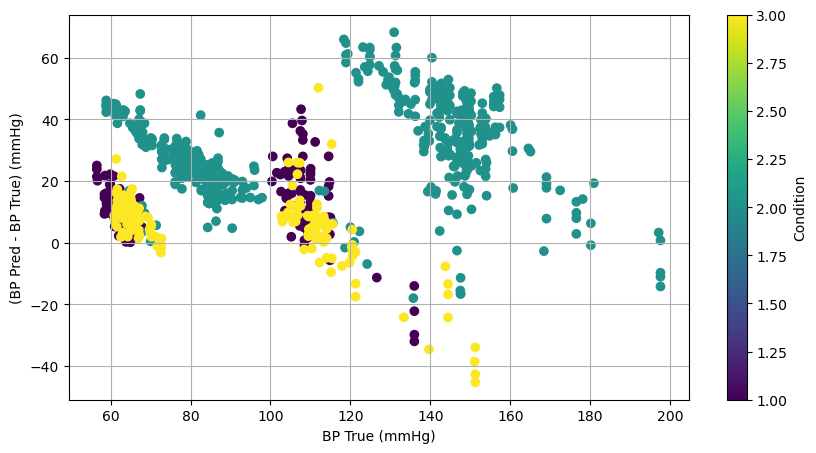

In [ ]:
true_min = result_sub[sub][:, 5].min(dim=1).values    # (N,)
true_max = result_sub[sub][:, 5].max(dim=1).values    # (N,)
pred_min = result_sub[sub][:, 6].min(dim=1).values    # (N,)
pred_max = result_sub[sub][:, 6].max(dim=1).values    # (N,)
condition = profile_sub[sub]["condition"]             # (N,)
diff_min = pred_min - true_min              
diff_max = pred_max - true_max 

# plot first sample's diff where x is true and y is diff
# color by condition
plt.figure(figsize=(10, 5))
plt.scatter(true_min, diff_min, c=condition, cmap="viridis")
plt.scatter(true_max, diff_max, c=condition, cmap="viridis")
# label color and condition
plt.colorbar(label="Condition")
plt.xlabel("BP True (mmHg)")
plt.ylabel("(BP Pred - BP True) (mmHg)")
plt.grid()
plt.show()

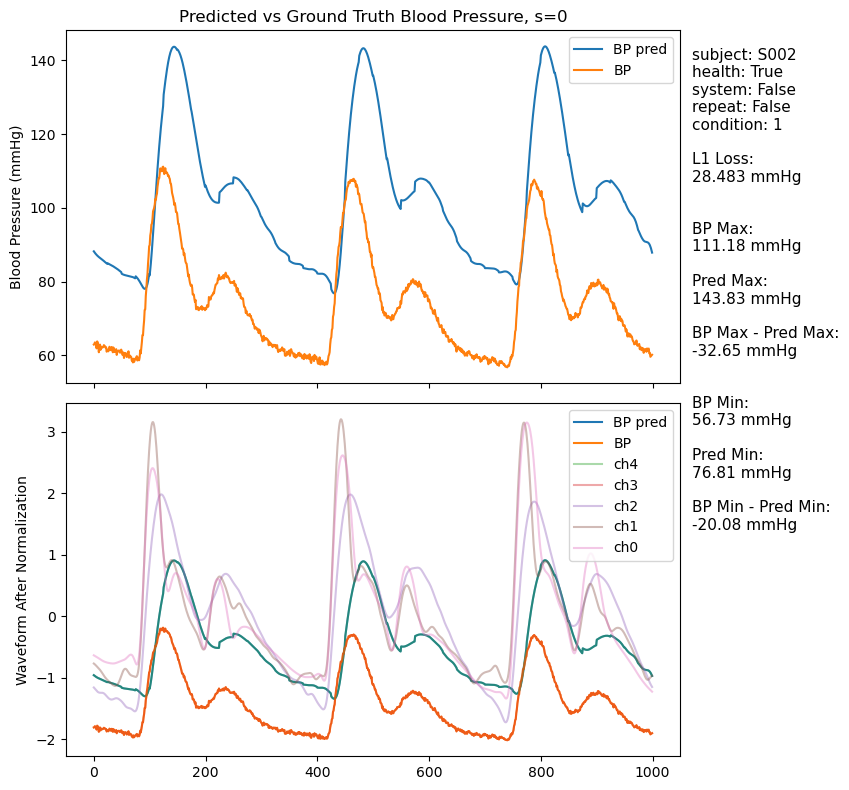

In [ ]:
""" plot """

l1_loss = torch.nn.functional.l1_loss(
    result_sub[sub][s, 5], result_sub[sub][s, 6]
)
bp_pred = result_sub[sub][s, 6]
bp_true = result_sub[sub][s, 5]
bp_pred_max, bp_pred_min = bp_pred.max().item(), bp_pred.min().item()
bp_true_max, bp_true_min = bp_true.max().item(), bp_true.min().item()

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)
axes[0].plot(result_sub[sub][s, 6], label="BP pred")
axes[0].plot(result_sub[sub][s, 5], label="BP")     
axes[0].set_ylabel("Blood Pressure (mmHg)")
axes[0].legend()
axes[0].set_title("Predicted vs Ground Truth Blood Pressure, s={}".format(s))
axes[1].plot(result_sub[sub][s, 4], label="BP pred")              
axes[1].plot(result_sub[sub][s, 3], label="BP")                   
for c in range(result_sub[sub].shape[1] - 3, -1, -1):             
    axes[1].plot(result_sub[sub][s, c], label=f"ch{c}", alpha=0.4)
axes[1].set_ylabel("Waveform After Normalization")
axes[1].legend()
# metadata on the right side
text_x = 1.02 
text_y = 0.95
meta_text = "\n".join(
    [f"{k}: {v}" for k, v in profile_sub[sub].iloc[s][:5].items()]
)
stat_text = (
    f"L1 Loss:\n{l1_loss.item():.3f} mmHg\n\n\n"
    f"BP Max:\n{bp_true_max:.2f} mmHg\n\n"
    f"Pred Max:\n{bp_pred_max:.2f} mmHg\n\n"
    f"BP Max - Pred Max:\n{(bp_true_max - bp_pred_max):.2f} mmHg\n\n\n"
    f"BP Min:\n{bp_true_min:.2f} mmHg\n\n"
    f"Pred Min:\n{bp_pred_min:.2f} mmHg\n\n"
    f"BP Min - Pred Min:\n{(bp_true_min - bp_pred_min):.2f} mmHg"
)
fig.text(
    text_x, text_y,
    f"{meta_text}\n\n{stat_text}",
    ha="left", va="top", fontsize=11, transform=axes[0].transAxes
)
plt.tight_layout()
plt.show()